In [1]:
import numpy as np
import datetime

import torch
import torch.optim as optim
import torch.nn as nn
import torch.functional as F
from torch.utils.data import DataLoader, TensorDataset, random_split
from torch.utils.tensorboard import SummaryWriter

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [2]:
class StepByStep(object):
    def __init__(self, model, loss_fn, optimizer):
        self.model = model
        self.loss_fn = loss_fn
        self.optimizer = optimizer
        self.device = 'cuda' if torch.cuda.is_available() else 'cpu'
        self.model.to(self.device)
        self.train_loader = None
        self.val_loader = None
        self.writer = None
        self.losses = []
        self.val_losses = []
        self.total_epochs = 0
        self.train_step = self._make_train_step()
        self.val_step = self._make_val_step()

    def to(self, device):
        self.device = device
        self.model.to(self.device)

    def set_loaders(self, train_loader, val_loader=None):
        self.train_loader = train_loader
        self.val_loader = val_loader

    def set_tensorboard(self, name, folder='runs'):
        suffix = datetime.datetime.now().strftime('%Y%m%d%H%M%S')
        self.writer = SummaryWriter('{}/{}_{}'.format(
            folder, name, suffix
        ))

    def _make_train_step(self):
        def perform_train_step(x, y):
            self.model.train()
            yhat = self.model(x)
            loss = self.loss_fn(yhat, y)
            loss.backward()
            self.optimizer.step()
            self.optimizer.zero_grad()
            return loss.item()
        return perform_train_step

    def _make_val_step(self):
        def perform_val_step(x, y):
            self.model.eval()
            yhat = self.model(x)
            loss = self.loss_fn(yhat, y)
            return loss.item()
        return perform_val_step

    def _mini_batch(self, validation=False):
        if validation:
            data_loader = self.val_loader
            step = self.val_step
        else:
            data_loader = self.train_loader
            step = self.train_step

        if data_loader == None:
            return None

        mini_batch_losses = []
        for x_batch, y_batch in data_loader:
            x_batch = x_batch.to(self.device)
            y_batch = y_batch.to(self.device)
            mini_batch_loss = step(x_batch, y_batch)
            mini_batch_losses.append(mini_batch_loss)
        loss = np.mean(mini_batch_losses)
        return loss

    def set_seed(self, seed=42):
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = False  # do not find the fastest algorithm
        torch.manual_seed(seed)
        np.random.seed(seed)

    def train(self, n_epochs, seed=42):
        self.set_seed(seed)
        for epoch in range(n_epochs):
            self.total_epochs += 1
            loss = self._mini_batch(validation=False)
            self.losses.append(loss)
            with torch.no_grad():
                val_loss = self._mini_batch(validation=True)
                self.val_losses.append(val_loss)
            if self.writer:
                scalars = {'training': loss}
                if val_loss is not None:
                    scalars.update({'validation': val_loss})
                self.writer.add_scalars(main_tag='loss', tag_scalar_dict=scalars, global_step=epoch)
        if self.writer:
            self.writer.flush()

    def save_checkpoint(self, filename):
        checkpoint = {
            'epoch': self.total_epochs,
            'model_state_dict': self.model.state_dict(),
            'optimizer_state_dict': self.optimizer.state_dict(),
            'loss': self.losses,
            'val_loss': self.val_losses
        }
        torch.save(checkpoint, filename)

    def load_checkpoint(self, filename):
        checkpoint = torch.load(filename)
        self.model.load_state_dict(checkpoint['model_state_dict'])
        self.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
        self.total_epochs = checkpoint['epoch']
        self.losses = checkpoint['loss']
        self.val_losses = checkpoint['val_loss']
        self.model.train()

    def predict(self, x):
        self.model.eval() 
        x_tensor = torch.as_tensor(x).float()
        y_hat_tensor = self.model(x_tensor.to(self.device))
        self.model.train()
        return y_hat_tensor.detach().cpu().numpy()

    def plot_losses(self):
        fig = plt.figure(figsize=(10, 4))
        plt.plot(self.losses, label='Training Loss', c='b')
        if self.val_loader:
            plt.plot(self.val_losses, label='Validation Loss', c='r')
        plt.yscale('log')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.tight_layout()
        return fig

    def add_graph(self):
        if self.train_loader and self.writer:
            x_dummy, y_dummy = next(iter(self.train_loader))
            self.writer.add_graph(self.model, x_dummy.to(self.device))

In [3]:
%run -i datagen.py
%run -i datapre_v2.py

In [4]:
%%writefile model_v4.py
lr = 0.1
torch.manual_seed(42)
model = nn.Sequential(nn.Linear(1, 1))
optimizer = optim.SGD(model.parameters(), lr=lr)
loss_fn = nn.MSELoss(reduction='mean')

Overwriting model_v4.py


In [5]:
%run -i model_v4.py
print(model.state_dict())

OrderedDict({'0.weight': tensor([[0.7645]]), '0.bias': tensor([0.8300])})


In [6]:
sbs = StepByStep(model, loss_fn, optimizer)
sbs.set_loaders(train_loader, val_loader)
sbs.set_tensorboard('classy')
print(sbs.model == model)
print(sbs.model)

True
Sequential(
  (0): Linear(in_features=1, out_features=1, bias=True)
)


In [7]:
sbs.train(n_epochs=200)
print(model.state_dict())
print(sbs.total_epochs)

OrderedDict({'0.weight': tensor([[1.9416]], device='cuda:0'), '0.bias': tensor([1.0235], device='cuda:0')})
200


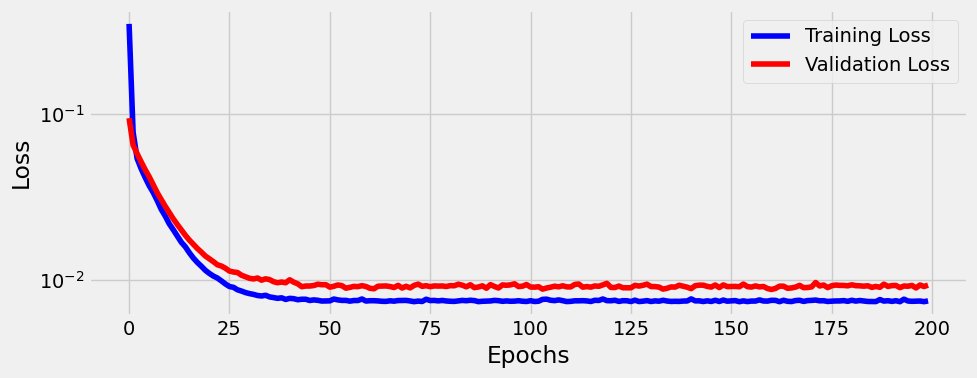

In [8]:
fig = sbs.plot_losses()

In [9]:
new_data = np.array([.5, .3, .7]).reshape(-1, 1)
print(new_data)
predictions = sbs.predict(new_data)
print(predictions)

[[0.5]
 [0.3]
 [0.7]]
[[1.9942763]
 [1.605955 ]
 [2.3825977]]


## Checkpointing

We still need to specify model when loading.

In [10]:
sbs.save_checkpoint('model_checkpoint.pth')

In [11]:
%run -i datagen.py
%run -i datapre_v2.py
%run -i model_v4.py
print(model.state_dict())

<Figure size 640x480 with 0 Axes>

OrderedDict({'0.weight': tensor([[0.7645]]), '0.bias': tensor([0.8300])})


In [12]:
new_sbs = StepByStep(model, loss_fn, optimizer)
print(model.state_dict())

OrderedDict({'0.weight': tensor([[0.7645]], device='cuda:0'), '0.bias': tensor([0.8300], device='cuda:0')})


In [13]:
new_sbs.load_checkpoint('model_checkpoint.pth')
print(model.state_dict())

OrderedDict({'0.weight': tensor([[1.9416]], device='cuda:0'), '0.bias': tensor([1.0235], device='cuda:0')})


/tmp/ipykernel_82053/929315685.py:104: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  checkpoint = torch.load(filename)


OrderedDict({'0.weight': tensor([[1.9416]], device='cuda:0'), '0.bias': tensor([1.0235], device='cuda:0')})


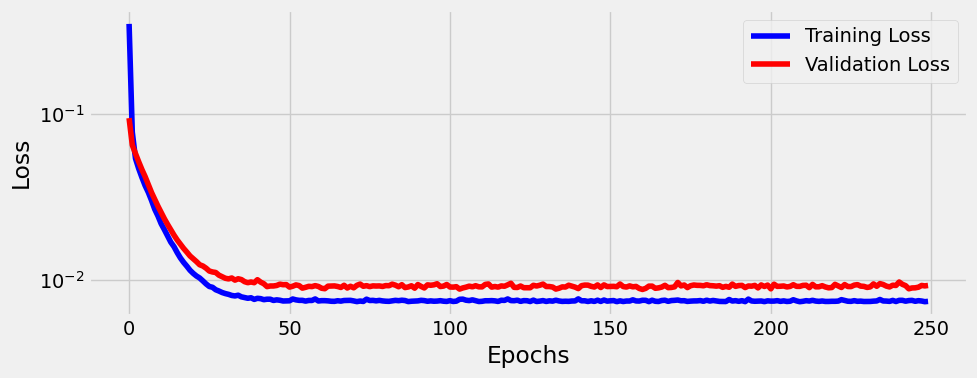

In [14]:
new_sbs.set_loaders(train_loader, val_loader)
new_sbs.train(n_epochs=50)
fig = new_sbs.plot_losses()
print(sbs.model.state_dict())